In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.special
import itertools as it
from ast import literal_eval

In [2]:
"""This code was taken and modified from https://doi.org/10.1002/aenm.202202962"""

def get_simplex_vertices(n_elems):
	# Initiate array of vertice coordinates
	vertices = np.zeros((n_elems, n_elems-1))

	for idx in range(1, n_elems):
		# Get coordinate of the existing dimensions as the mean of the existing vertices
		vertices[idx] = np.mean(vertices[:idx], axis=0)
		
		# Get the coordinate of the new dimension by ensuring it has a unit 
		# Distance to the first vertex at the origin 
		vertices[idx][idx-1] = (1 - np.sum(vertices[idx][:-1]**2))**0.5
		
	return vertices

def cartesians_to_molar_fractions(rs):
    # Make into numpy
    rs = np.asarray(rs)
    # Add column of ones to ´rs´ to account for the restriction
    # that the molar fractions must sum to unity
    rs = np.concatenate((rs, np.ones((rs.shape[0], 1))), axis=1)

    # Get vertices of the multidimensional simplex
    n_elems = rs.shape[1]
    vertices = get_simplex_vertices(n_elems)

    # Add column of ones to ´vertices´ to account for the restriction
    # that the molar fractions must sum to unity
    vertices = np.concatenate((vertices, np.ones((vertices.shape[0], 1))), axis=1)

    # Get molar fractions corresponding to the cartesian coordinates
    # r = fV <=> r^T = (fV)^T = V^T f^T (i.e. on the form Ax = b that np.linalg.solve takes as input)
    return np.linalg.solve(vertices.T, rs.T).T


def molar_fractions_to_cartesians(fs):
	# Make into numpy
	fs = np.asarray(fs)

	if fs.ndim == 1:
		fs = np.reshape(fs, (1, -1))

	# Get vertices of the multidimensional simplex
	n_elems = fs.shape[1]
	vertices = get_simplex_vertices(n_elems)	
	vertices_matrix = vertices.T
	
	# Get cartisian coordinates corresponding to the molar fractions
	return np.dot(vertices_matrix, fs.T)



def count_elements(elements, n_elems):
	count = np.zeros(n_elems, dtype=int)
	for elem in elements:
	    count[elem] += 1
	return count

def get_molar_fractions(step_size, n_elems, total=1., return_number_of_molar_fractions=False):
	#Get all molar fractions with the given step size
	interval = int(total/step_size)
	n_combs = scipy.special.comb(n_elems+interval-1, interval, exact=True)
	
	if return_number_of_molar_fractions:
		return n_combs
		
	counts = np.zeros((n_combs, n_elems), dtype=int)

	for i, comb in enumerate(it.combinations_with_replacement(range(n_elems), interval)):
		counts[i] = count_elements(comb, n_elems)

	return counts*step_size


# Set the number of ticks to make
n_ticks = 5
tick_labels = True

# Specify vertices as molar fractions
fs_vertices = [[1., 0., 0.],
			   [0., 1., 0.],
			   [0., 0., 1.]]

# Get height of triangle
h = 3**0.5/2

# Get cartesian coordinates of vertices
xs_vertices, ys_vertices = molar_fractions_to_cartesians(fs_vertices)

# Define padding to put the vertex text neatly
pad = [[-0.06, -0.06],
	   [ 0.06, -0.06],
	   [ 0.00,  0.08]]
has = ['right', 'left', 'center']
vas = ['top', 'top', 'bottom']

# Make ticks and tick labels on the triangle axes
left, right, top = np.concatenate((xs_vertices.reshape(-1,1), ys_vertices.reshape(-1,1)), axis=1)

tick_size = 0.035
bottom_ticks = 0.8264*tick_size * (right - top)
right_ticks = 0.8264*tick_size * (top - left)
left_ticks = 0.8264*tick_size * (left - right)

def make_triangle_ticks(ax, start, stop, tick, n, offset=(0., 0.),
						fontsize=12, ha='center', tick_labels=True):
	r = np.linspace(0, 1, n+1)
	x = start[0] * (1 - r) + stop[0] * r
	x = np.vstack((x, x + tick[0]))
	y = start[1] * (1 - r) + stop[1] * r
	y = np.vstack((y, y + tick[1]))
	ax.plot(x, y, 'black', lw=1., zorder=1)
	
	if tick_labels:
		# Add tick labels
		for xx, yy, rr in zip(x[0], y[0], r):
			ax.text(xx+offset[0], yy+offset[1], f'{rr*100.:.0f}',
					fontsize=fontsize, ha=ha)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
	new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
		'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
		cmap(np.linspace(minval, maxval, n)))
	return new_cmap

def prepare_triangle_plot(ax, elems):
	# Set axis limits
	ax.set_xlim(-0.05, 1.05)
	ax.set_ylim(-0.05, h+0.05)

	# Plot triangle edges
	ax.plot([0., 0.5], [0., h], '-', color='black', zorder=0)
	ax.plot([0.5, 1.], [h, 0.], '-', color='black', zorder=0)
	ax.plot([0., 1.], [0., 0.], '-', color='black', zorder=0)
	
	# Remove spines
	for direction in ['right', 'left', 'top', 'bottom']:
		ax.spines[direction].set_visible(False)
	
	# Remove tick and tick labels
	ax.tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
	ax.set_aspect('equal')

	make_triangle_ticks(ax, right, left, bottom_ticks, n_ticks, offset=(0.03, -0.08), ha='center', tick_labels=tick_labels)
	make_triangle_ticks(ax, left, top, left_ticks, n_ticks, offset=(-0.03, -0.015), ha='right', tick_labels=tick_labels)
	make_triangle_ticks(ax, top, right, right_ticks, n_ticks, offset=(0.015, 0.02), ha='left', tick_labels=tick_labels)
    
	# Show axis labels (i.e. atomic percentages)
	ax.text(0.5, -0.14, f'{elems[0]} content (at.%)', rotation=0., fontsize=12, ha='center', va='center')
	ax.text(0.9, 0.5, f'{elems[1]} content (at.%)', rotation=-60., fontsize=12, ha='center', va='center')
	ax.text(0.1, 0.5, f'{elems[2]} content (at.%)', rotation=60., fontsize=12, ha='center', va='center')
	
	# Show the chemical symbol as text at each vertex
	for idx, (x, y, (dx, dy)) in enumerate(zip(xs_vertices, ys_vertices, pad)):
		ax.text(x+dx, y+dy, s=elems[idx], fontsize=14, ha=has[idx], va=vas[idx])
	
	return ax


# Function to create the contour plot inside the triangle
def make_plot(grid, activity, elements, scatter=False, contour_levels=15, points=None, points_2=None):
	# Define colormap
	cmap = truncate_colormap(plt.get_cmap('viridis'), minval=0.2, maxval=1.0, n=100)
	
	# Create figure and axis
	fig= plt.figure(figsize=(8, 4), dpi=400)
	gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])  # Two plots and one for color bar
	# Adjust the spacing between the two plots
	fig.subplots_adjust(wspace=0.4)

    # First axis for the triangle plot with first scatter points
	ax1 = fig.add_subplot(gs[0])
	prepare_triangle_plot(ax1, elems=elements)

	if points is not None:
		# First scatter plot
		ax1.scatter(points_x, points_y, marker='o', c='#cd81b5', s=3)

	# Second axis for the triangle plot with second scatter points
	ax2 = fig.add_subplot(gs[1])
	prepare_triangle_plot(ax2, elems=elements)

	if points_2 is not None:
		# Second scatter plot
		ax2.scatter(points_2_x, points_2_y, marker='o', c='#6eade1', s=3)
		
	# Plot contour inside the triangle
	plot_kwargs = dict(cmap=cmap, levels=contour_levels, zorder=0, vmin=activity.min(), vmax=activity.max())	
	if scatter:
		# Scatter plot if enabled
		contour = ax1.scatter(grid_x, grid_y, marker='o', c=activity, cmap=cmap, s=5)
		contour = ax2.scatter(grid_x, grid_y, marker='o', c=activity, cmap=cmap, s=5)
	else:
		# Contour plot
		contour = ax1.tricontourf(grid_x, grid_y, activity, **plot_kwargs)
		contour = ax2.tricontourf(grid_x, grid_y, activity, **plot_kwargs)

	# Add a shared color bar on the third subplot (gs[2])
	cax = fig.add_subplot(gs[2])
	cbar = fig.colorbar(contour, cax=cax)
	cbar.set_label('Activity', rotation=270, labelpad=10)

	return fig, (ax1, ax2)


In [3]:
#Preparing the data
def pso_data_ternary(load_location, maximum):
    #Loading datalog
    datalog = pd.read_csv(load_location, sep='\t')  

    #Reading "Elements" columns from string to list
    datalog['Elements'] = datalog["Elements"].apply(lambda x: literal_eval(x))

    #Creating np.array of "Position" column and dropping the string type "Position" column
    position = []
    for k in range(len(datalog)):
        position.append(list(np.fromstring(datalog['Position'][k][1:-1], dtype=float, sep=' ')))
    position = np.array(position)  
    datalog = datalog.drop(columns=['Position'])
    datalog = pd.concat([datalog, pd.DataFrame(([[k] for k in position]), columns = ['Position'])], axis = 1)

    #Create array for data
    position_array = np.vstack(datalog['Position'].to_numpy())
    #Make array based on element which joined 
    #Manually choosen
    ternary_data = np.column_stack((position_array[:, 0], position_array[:, 2], position_array[:, 1] + position_array[:, 3] + position_array[:, 4]))
    ternary_data = np.column_stack((ternary_data, datalog['Activity']))
    return ternary_data

def grid_data_ternary(load_location, join):
    grid = pd.read_csv(load_location, sep='\t')
    grid[', '.join(join)] = grid[join].sum(axis=1).to_numpy()

    grid_plot = grid[['Ag', 'Pd', ', '.join(join), 'Activity']].round(4)

    idx = grid_plot.groupby(['Ag', 'Pd', ', '.join(join)])['Activity'].idxmax()
    grid_select = grid_plot.loc[idx]
    grid_array = grid_select.to_numpy()
    return grid_array

In [5]:
#Importing the data of model 2
maximum = np.array([0.15, 0., 0.85, 0., 0.]) #Data from Grid
grid_data = grid_data_ternary('../result/grid_data/model2/grid_data_19.txt', join = ['Ir', 'Pt', 'Ru'])
pso_data_negative = pso_data_ternary('../raw_data/composition_vs_activity/model2/PSO/PSO_1_3.txt', maximum)
pso_data_positive = pso_data_ternary('../raw_data/composition_vs_activity/model2/PSO/PSO_2_3.txt', maximum)

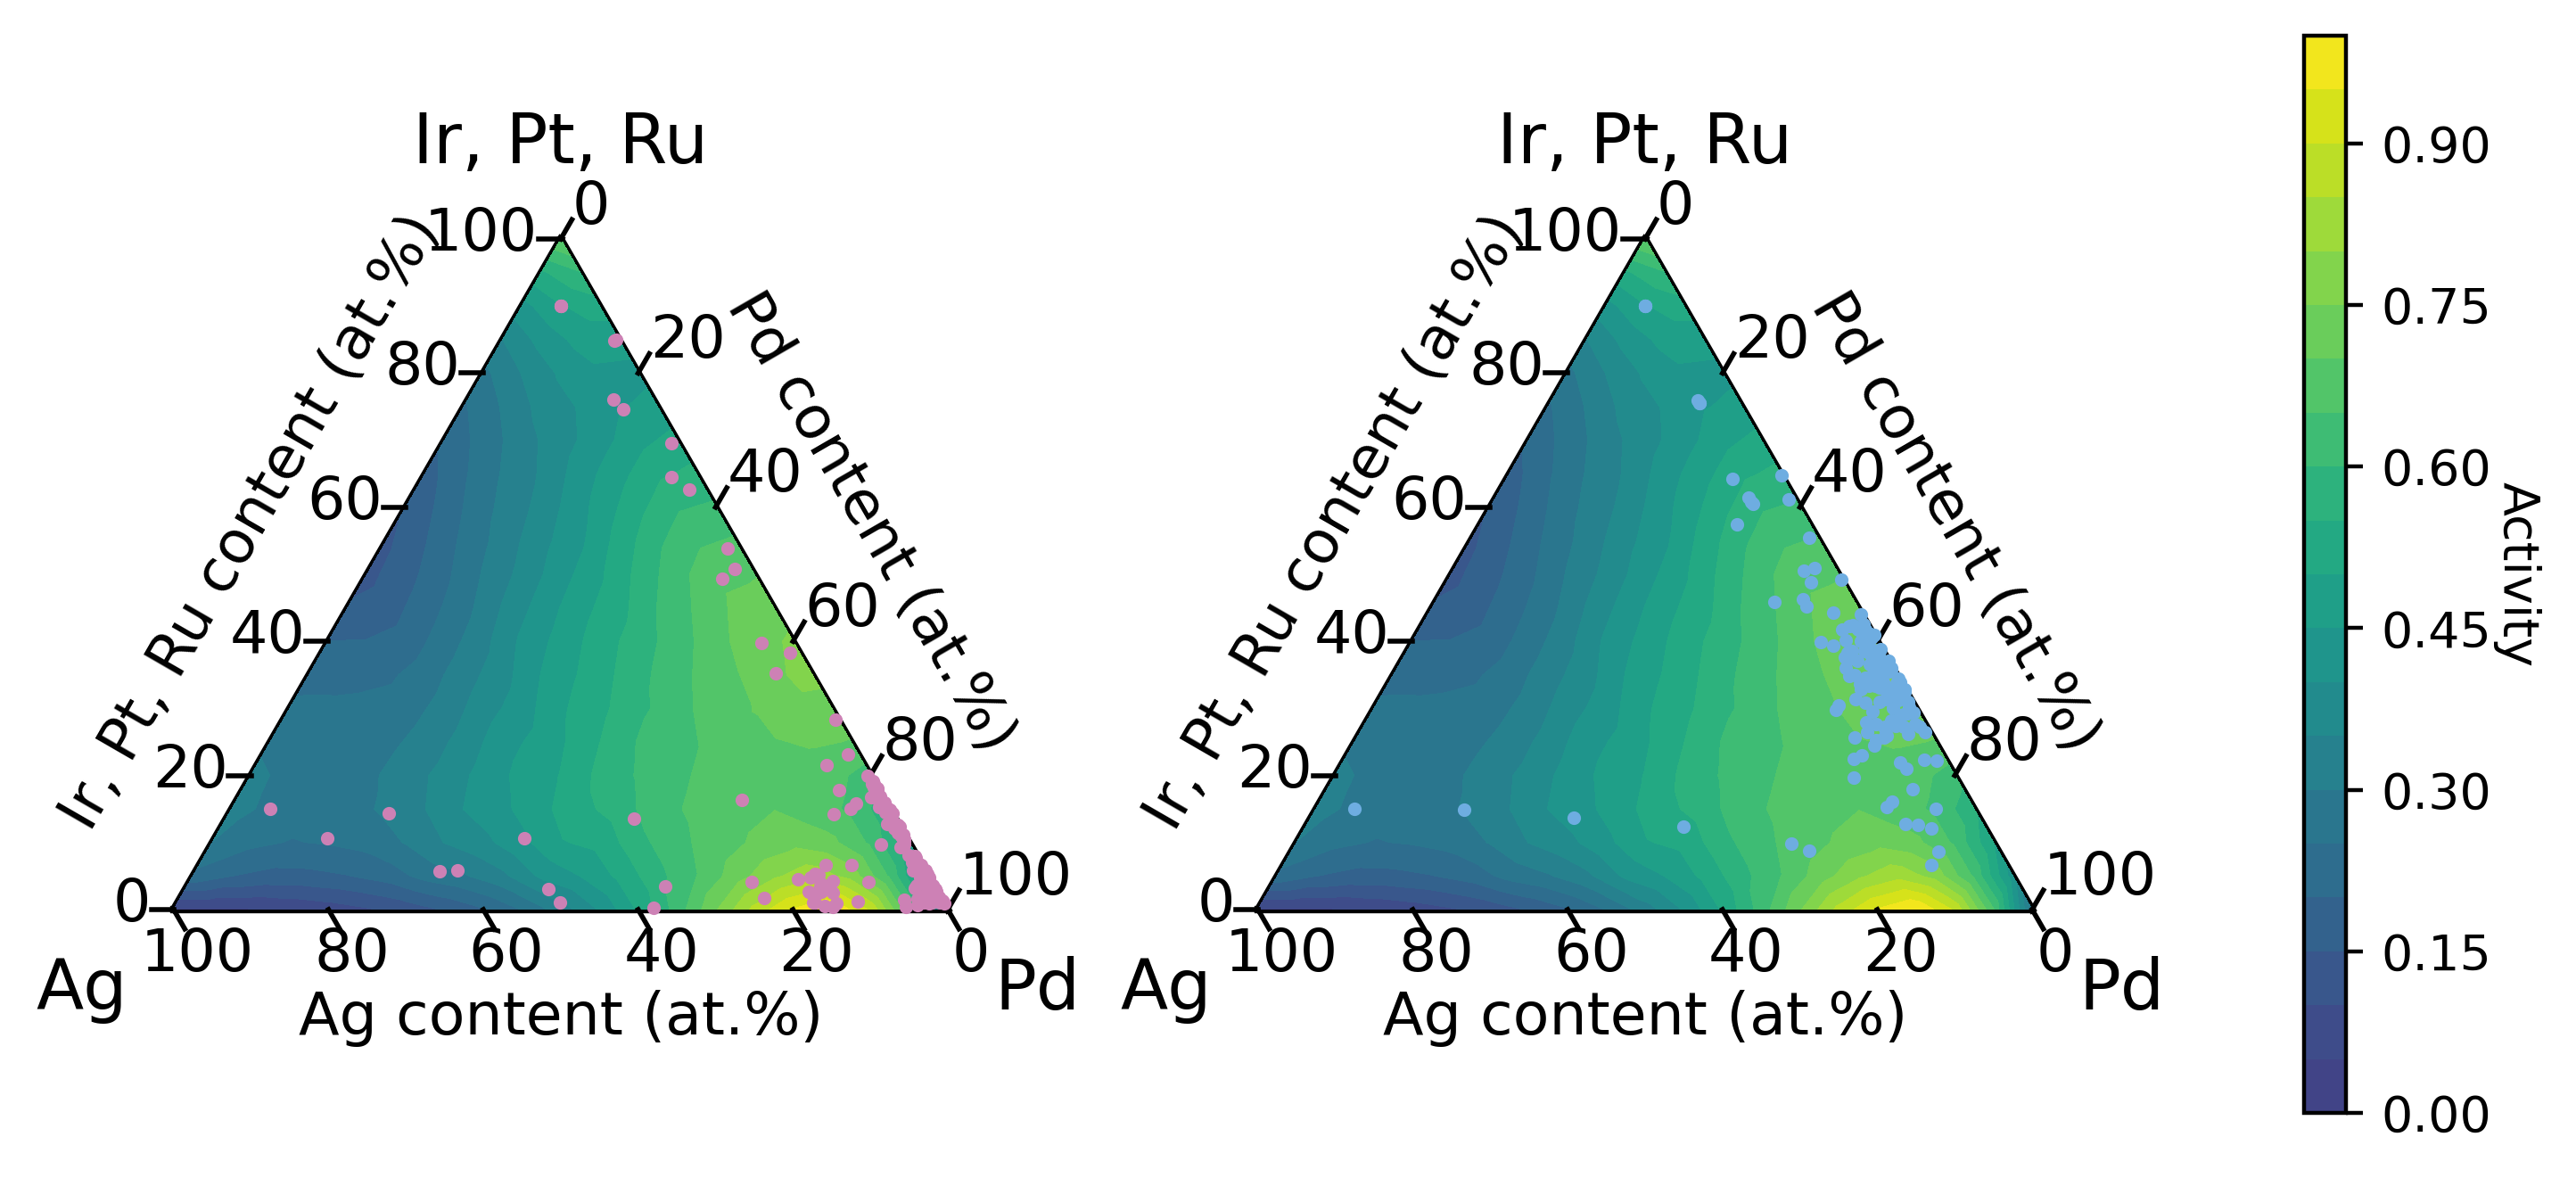

In [6]:
# Set the number of elements (ternary system)
n_elems = 3


# Convert molar fractions to Cartesian coordinates
grid = molar_fractions_to_cartesians(grid_data[:, 0:3])
points = molar_fractions_to_cartesians(pso_data_negative[:, 0:3])
points_2 = molar_fractions_to_cartesians(pso_data_positive[:, 0:3])


# Check if grid has correct shape (grid is 2D; molar fractions are in 3D)
grid_x, grid_y = grid
points_x, points_y = points
points_2_x, points_2_y = points_2


# Set elements (chemical symbols)
elements = ['Ag', 'Pd', 'Ir, Pt, Ru']  # Placeholder element symbols

# Create and show the plot
fig, (ax1, ax2)= make_plot(grid, activity = grid_data[:, 3]/grid_data[:, 3].max(), elements = elements, scatter=False, contour_levels=20, points=points, points_2=points_2)
plt.show()